# Creating Data Subsets
Here we will create subsets of data that can be passed into a multivariate time series regression

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [9]:
sales = pd.read_csv("../data/raw/test.csv", header=0, delimiter=",")
sku = pd.read_csv("../data/raw/sku.csv", header=0, delimiter=",")
geoParams = pd.read_csv("../data/raw/geo_params.csv", header=0, delimiter=",")

Merge the geo_params and sales data files. A different subset will be generated for each item (SKU) for every geographic cluster location. The data will be stored in a dictionary with:
- key: `geoCluster_ID` and `SKU`
- value: list of `date`, `price`, and `sales`

The dictionary will be written to a json file for convenience.

### Pre-process sku file

In [10]:
sku.keys()

Index(['SKU', 'Category', 'Type', 'brandId', 'lagerUnitQuantity', 'Units',
       'trademark', 'countryOfOrigin', 'Group'],
      dtype='object')

In [11]:
sku.loc[sku['SKU'].isin( [612845, 782787, 802382, 819149, 819150] ), "Category"] = "Yoghurts"

In [12]:
# Join datasets
sales.sort_values("date", inplace=True)
sales = sales.join(geoParams.set_index("geoCluster"),on="geoCluster", rsuffix="gC")
sales = pd.merge(sales, sku, how='left', on='SKU')

#### Clean Dataset

In [13]:
sales["qty"] = sales.sales
sales = sales.drop(labels='sales', axis='columns')

In [14]:
sales = sales[["date", "SKU", "Category", "geoCluster", "Group", "price_filled", "qty"]]

### Dataset v1 - Non timeseries 

In [15]:
def percentage_of_criterion_in_ds(list_of_indexes, df):
    """ Return the percentage the list_of_indexes has compared to the entire df's length
    """
    percentage = 100 * sum(list_of_indexes) / len(df)
    return percentage

In [19]:
## Exploratory Data Analysis

# # Shows you rows where qty is 0.001
# df_nts[df_nts["qty"] == 0.001]

# df_nts.describe(include='all')
# df_nts = df_nts.drop( df_nts[df_nts["price_filled"] >= 5000].index, axis=0 )
# df_nts[df_nts["qty"] == 0.001]
# df_nts[df_nts["price_filled"] < 50]

# df = df_nts[df_nts["Group"] == "Cheese"] 


# fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
# df.boxplot(column='price_filled',ax=axes[0]);
# df.hist(column='price_filled', ax=axes[1]);

sales.describe()

,SKU,geoCluster,price_filled,qty
count,202737.000000,202737.000000,202737.000000,0.0
mean,367044.202449,2244.779517,79.675751,NaN
std,300460.823849,359.694670,98.742848,NaN
min,24.000000,21.000000,0.000000,NaN
25%,39465.000000,2052.000000,23.690000,NaN
50%,363713.000000,2184.000000,39.690000,NaN
75%,642700.000000,2310.000000,68.090000,NaN
max,838137.000000,3230.000000,424.690000,NaN


# Box plots price_filled column on df

In [20]:
df_nts = copy( sales )

# Later ToDo where price_filled is 0 fix it.
print(f"Percentage of price_filled == 0 is {percentage_of_criterion_in_ds(df_nts['price_filled'] == 0, df_nts)}")
# drop it
df_nts = df_nts.drop(df_nts[df_nts['price_filled'] == 0].index, axis=0)


Percentage of price_filled == 0 is 0.7453005618116082


In [21]:
df_nts.describe(include="all")

,date,SKU,Category,geoCluster,Group,price_filled,qty
count,201226,201226.000000,201226,201226.000000,201226,201226.000000,0.0
unique,14,NaN,39,NaN,5,NaN,NaN
top,2021-07-19,NaN,Yoghurts,NaN,Bakery,NaN,NaN
freq,14479,NaN,27390,NaN,52118,NaN,NaN
mean,NaN,365901.280416,NaN,2244.783547,NaN,80.274034,NaN
std,NaN,300512.456851,NaN,360.057697,NaN,98.870304,NaN
min,NaN,24.000000,NaN,21.000000,NaN,4.990000,NaN
25%,NaN,39465.000000,NaN,2052.000000,NaN,24.190000,NaN
50%,NaN,363713.000000,NaN,2185.000000,NaN,39.790000,NaN
75%,NaN,642700.000000,NaN,2310.000000,NaN,68.190000,NaN


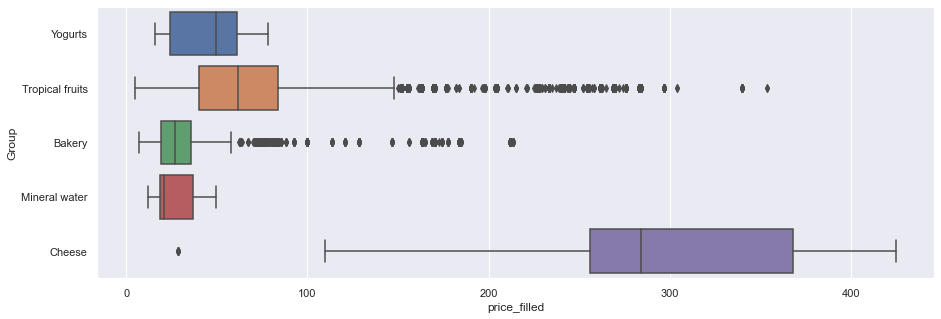

In [22]:
# boxplot_data = df_nts[np.intersect1d(df_nts.columns, ["price_filled", "qty"])]
# sns.boxplot(data=boxplot_data)
sns.set(rc = {'figure.figsize':(15,5)})
ax = sns.boxplot(x="price_filled", y="Group", data=df_nts, orient="h")

In [23]:
df_nts_out_IQR = df_nts
df_nts_outliers = df_nts["price_filled"]

Q1 = df_nts_outliers.quantile(0.25)
Q3 = df_nts_outliers.quantile(0.75)
IQR = Q3 - Q1

print(f'The lower IQR is: {Q1 - 1.5 * IQR}')
# lower IQR is negative, and the lower bound of price_filled is €0.09. We will not adjust this as it is reasonable given the products.

df_nts_out_IQR = df_nts_outliers[(df_nts_outliers < (Q3 + 1.5 * IQR))]
print((len(df_nts)-len(df_nts_out_IQR))*100/len(df_nts))
df_nts_outliers.describe()
# 11.6% data being dropped with 1.5*IQR outlier drop method.

The lower IQR is: -41.81
16.45214833073261


count    201226.000000
mean         80.274034
std          98.870304
min           4.990000
25%          24.190000
50%          39.790000
75%          68.190000
max         424.690000
Name: price_filled, dtype: float64

In [24]:
df_nts_out_floor_cap = df_nts
df_nts_outliers = df_nts["price_filled"]

df_nts_bottom = df_nts_outliers.quantile(0.10)
df_nts_top = df_nts_outliers.quantile(0.90)

df_nts_out_floor_cap = df_nts_outliers[~((df_nts_outliers < df_nts_bottom) | (df_nts_outliers > df_nts_top))]
print((len(df_nts)-len(df_nts_out_floor_cap))/len(df_nts))

0.19185890491288402


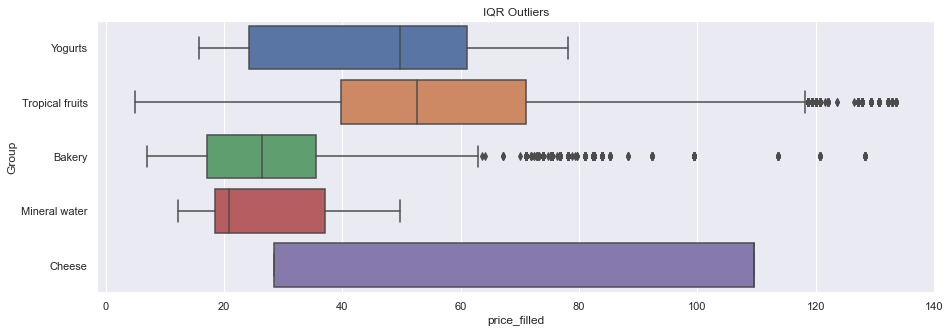

In [25]:
ax = sns.boxplot(x="price_filled", y="Group", data=df_nts.loc[df_nts_out_IQR.index, :], orient="h").set(title='IQR Outliers')

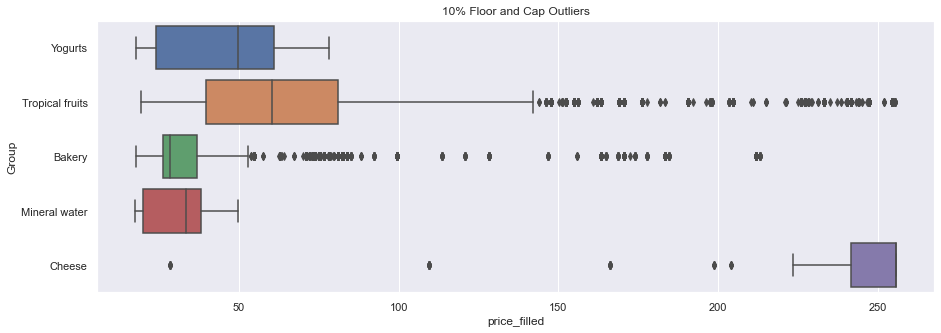

In [26]:
ax = sns.boxplot(x="price_filled", y="Group", data=df_nts.loc[df_nts_out_floor_cap.index, :], orient="h").set(title='10% Floor and Cap Outliers')

In [28]:
# new values of data after outliers removal and cleaning
df_nts.loc[df_nts_out_IQR.index, :].describe()

,SKU,geoCluster,price_filled,qty
count,168120.000000,168120.000000,168120.00000,0.0
mean,375850.660153,2240.662848,39.64242,NaN
std,306761.890563,370.042277,22.04560,NaN
min,24.000000,21.000000,4.99000,NaN
25%,39465.000000,2052.000000,21.39000,NaN
50%,363713.000000,2185.000000,35.59000,NaN
75%,666058.000000,2310.000000,52.59000,NaN
max,838137.000000,3230.000000,133.59000,NaN


In [29]:
# previous values of data before outliers removal and cleaning (for comparison)
df_nts.describe()

,SKU,geoCluster,price_filled,qty
count,201226.000000,201226.000000,201226.000000,0.0
mean,365901.280416,2244.783547,80.274034,NaN
std,300512.456851,360.057697,98.870304,NaN
min,24.000000,21.000000,4.990000,NaN
25%,39465.000000,2052.000000,24.190000,NaN
50%,363713.000000,2185.000000,39.790000,NaN
75%,642700.000000,2310.000000,68.190000,NaN
max,838137.000000,3230.000000,424.690000,NaN


In [30]:
df_nts[df_nts["qty"]>50]


,date,SKU,Category,geoCluster,Group,price_filled,qty


In [33]:
df_nts = df_nts.loc[df_nts_out_IQR.index, :]
df_nts.to_csv("../data/processed/test_data_processed.csv", index=False)

In [ ]:
# ---------- Testing ----------
# df_temp = df_nts[df_nts["price_filled"] == 0]
# df_temp.to_csv("temp.csv", index=False)
#df_nts.describe(include='all')

### Dataset  - Time series

In [ ]:
# ToDo - requirements will be given by sergio later.
sales

## Depricated Code

In [ ]:
SKUset = set(sales["SKU"])
salesSubsets = {}
for geoCluster in tqdm(enumerate(geoParams["geoCluster"]), total=len(geoParams["geoCluster"])):
    for sku in SKUset:
        salesSKU = sales[sales["SKU"]==sku]
        salesSKUgeoCluster = salesSKU[salesSKU["geoCluster"]==geoCluster[1]]
        key = f'{geoCluster[1]}_{sku}'
        salesSubsets[key] = salesSKUgeoCluster[["date", "price_filled", "sales"]].values.tolist()

In [ ]:
salesSubsets_csv = "../data/processed/sales_subsets.csv"
try:
    with open(salesSubsets_csv, 'w') as file:
        json.dump(salesSubsets, file)

except IOError:
    print("I/O error")

# Reload processed subsets

In [ ]:
with open(salesSubsets_csv) as file:
    salesSubsets = json.load(file)

In [ ]:
sales = sales[["date", "SKU", "Category", "geoCluster", "Group", "price_filled", "qty" ]]